# Steam Data

En este notebook vamos a trabajar con los datos de la plataforma de videojuegos Steam. Los datos de esta plataforma no son facilmente accesibles a través de su API ya que es bastante limitada. 
En este proyecto se van a necesitar datos desde historicos que la API no nos puede proporcionar pero sí que hay usuarios que han ido recopilando estos datos durante muchos. Es el caso de este repositorio de Kaggle donde hemos encontrado los datos suficientes para realizar el proyecto: https://www.kaggle.com/michau96/popularity-of-games-on-steam
Vamos a analizarlos y a ver qué es lo que contiene

Importamos las librerías necesarias para analizar los datos

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.linear_model import LinearRegression
import missingno as msno

In [2]:
#Ampliamos el texto de nuestros gráficos para verlos mejor
plt.rcParams.update({'font.size': 16})

Leemos nuestro documento del que vamos a extraer los datos con un encoding de latin para evitar errores. Usamos este encoding ya que sin usarlos aparecían errores y caracteres Unicode que luego dificultaban la unión con otros datasets

In [3]:
df_steam = pd.read_csv('Popularity_games_Steam_Charts.csv', encoding='latin-1')

Hacemos un analisis exploratorio de los datos para ve qué contienen

In [4]:
df_steam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83789 entries, 0 to 83788
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gamename       83789 non-null  object 
 1   year           83789 non-null  int64  
 2   month          83789 non-null  object 
 3   avg            83789 non-null  float64
 4   gain           82529 non-null  float64
 5   peak           83789 non-null  int64  
 6   avg_peak_perc  83789 non-null  object 
dtypes: float64(2), int64(2), object(3)
memory usage: 4.5+ MB


Tamaño del dataset

In [5]:
df_steam.shape

(83789, 7)

In [6]:
df_steam.head()

,gamename,year,month,avg,gain,peak,avg_peak_perc
0,Counter-Strike: Global Offensive,2021,February,741013.24,-2196.42,1123485,65.9567%
1,Counter-Strike: Global Offensive,2021,January,743209.66,25405.91,1124553,66.0893%
2,Counter-Strike: Global Offensive,2020,December,717803.75,49049.17,1164396,61.646%
3,Counter-Strike: Global Offensive,2020,November,668754.58,55087.89,1037464,64.4605%
4,Counter-Strike: Global Offensive,2020,October,613666.69,6816.37,943876,65.0156%


In [7]:
df_steam.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,year,avg,gain,peak
count,83789.00000,83789.00000,82529.00000,83789.00000
mean,2017.33871,2792.01701,-10.24556,5518.87691
std,2.23759,26484.80416,3789.94401,50155.70591
min,2012.00000,0.00000,-250248.99000,0.00000
25%,2016.00000,53.25000,-38.31000,138.00000
50%,2018.00000,204.27000,-1.63000,502.00000
75%,2019.00000,771.65000,22.32000,1741.00000
max,2021.00000,1584886.77000,426446.12000,3236027.00000


Vemos los valores que faltan

<AxesSubplot:>

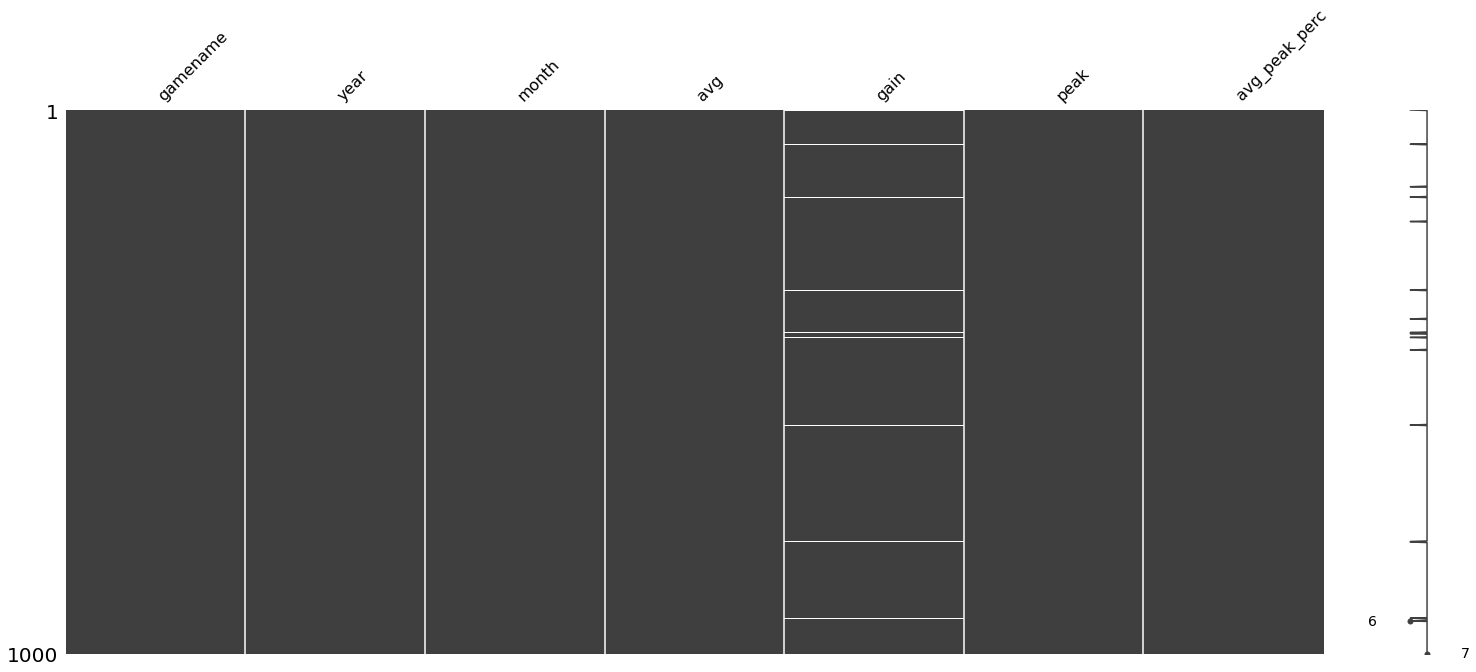

In [8]:
%matplotlib inline
msno.matrix(df_steam.sample(1000))

In [9]:
nan_values = ((df_steam['gain'].isna().sum()/len(df_steam))*100).round(2)
print('Los valores vacíos de la columna gain representan un {} % de los valores totales'.format(nan_values))

Los valores vacíos de la columna gain representan un 1.5 % de los valores totales


Analizamos cuales son los datos que faltan

In [10]:
df_steam.isna().sum()

gamename            0
year                0
month               0
avg                 0
gain             1260
peak                0
avg_peak_perc       0
dtype: int64

Vemos que todas pertenecen a la columna de gain. Vamos a mostrar las filas con esos valores

In [11]:
df1 = df_steam[df_steam.isna().any(axis=1)]
df1.head(n=10)

,gamename,year,month,avg,gain,peak,avg_peak_perc
103,Counter-Strike: Global Offensive,2012,July,932.57,NaN,1642,56.7948%
207,Dota 2,2012,July,52721.05,NaN,75041,70.2563%
255,PLAYERUNKNOWN'S BATTLEGROUNDS,2017,March,17551.14,NaN,67846,25.8691%
259,Apex Legends,2020,November,74957.26,NaN,117193,63.9605%
346,Rust,2013,December,9205.77,NaN,22571,40.7858%
450,Team Fortress 2,2012,July,45566.90,NaN,62321,73.1164%
521,Grand Theft Auto V,2015,April,192714.01,NaN,360761,53.4187%
584,Tom Clancy's Rainbow Six Siege,2015,December,7941.45,NaN,18130,43.8028%
653,Rocket League,2015,June,1.92,NaN,25,7.68%
742,Path of Exile,2013,October,19346.91,NaN,34371,56.2885%


Vemos que son algunos valores que están al principio cuando se recogen los datos o valores no recogidos. Estos huecos se rellenan con los valores medios agrupando por videojuegos y por año para tener una métrica más precisa.

In [12]:
df_steam['gain'] = df_steam.groupby(['gamename', 'year'])['gain'].transform(lambda x: x.fillna(x.mean()))

In [13]:
df_steam.isna().sum()

gamename           0
year               0
month              0
avg                0
gain             114
peak               0
avg_peak_perc      0
dtype: int64

Vemos como aún hay 114 valores que no hemos podido rellenar con la media. Los visualizamos a ver qué puede pasar.

In [14]:
df2 = df_steam[df_steam.isna().any(axis=1)]
df1.head(n=10)

,gamename,year,month,avg,gain,peak,avg_peak_perc
103,Counter-Strike: Global Offensive,2012,July,932.57,NaN,1642,56.7948%
207,Dota 2,2012,July,52721.05,NaN,75041,70.2563%
255,PLAYERUNKNOWN'S BATTLEGROUNDS,2017,March,17551.14,NaN,67846,25.8691%
259,Apex Legends,2020,November,74957.26,NaN,117193,63.9605%
346,Rust,2013,December,9205.77,NaN,22571,40.7858%
450,Team Fortress 2,2012,July,45566.90,NaN,62321,73.1164%
521,Grand Theft Auto V,2015,April,192714.01,NaN,360761,53.4187%
584,Tom Clancy's Rainbow Six Siege,2015,December,7941.45,NaN,18130,43.8028%
653,Rocket League,2015,June,1.92,NaN,25,7.68%
742,Path of Exile,2013,October,19346.91,NaN,34371,56.2885%


Indagando más en los datos resulta que son valores únicos y no podemos conseguir la media para rellenarlos por lo que se procede a rellenarlo con 0.

In [15]:
df_steam['gain'].fillna(0, inplace=True)

In [16]:
df_steam.isna().sum()

gamename         0
year             0
month            0
avg              0
gain             0
peak             0
avg_peak_perc    0
dtype: int64

Analizamos el rango de años recogidos en el dataset


In [17]:
year_data = max(df_steam['year'])-min(df_steam['year'])
print("Tenemos datos de %d años" % year_data)

Tenemos datos de 9 años


¿De cuántos videojuegos únicos disponemos?

In [18]:
unique_vg = df_steam['gamename'].nunique()
print("Tenemos %d videojuegos diferentes en el dataset" % unique_vg)

Tenemos 1260 videojuegos diferentes en el dataset


### Procesamiento de fechas

Analizando las columnas del dataset vimos que no había columna específica de fechas. Se iban a rellenar con las columnas de los datos necesarios pero nos dimos cuenta de que también estaban mal formateadas, por lo que las formateamos bien para poder crear la columna de fecha

In [19]:
# Exploramos las columnas y vemos que month contiene espacios
df_steam['month'].unique()

array(['February ', 'January ', 'December ', 'November ', 'October ',
       'September ', 'August ', 'July ', 'June ', 'May ', 'April ',
       'March '], dtype=object)

In [20]:
# Procesamos los espacios en las columnas de meses.
df_steam['month'] = df_steam['month'].str.strip()
df_steam['month']

0        February
1         January
2        December
3        November
4         October
           ...   
83784        July
83785        June
83786         May
83787       April
83788       March
Name: month, Length: 83789, dtype: object

In [21]:
# Unificamos fechas para formatearlas en una columna de tipo date
df_steam['date'] = pd.to_datetime(df_steam['month'] + df_steam['year'].astype(str), format='%B%Y')
df_steam['date']

0       2021-02-01
1       2021-01-01
2       2020-12-01
3       2020-11-01
4       2020-10-01
           ...    
83784   2017-07-01
83785   2017-06-01
83786   2017-05-01
83787   2017-04-01
83788   2017-03-01
Name: date, Length: 83789, dtype: datetime64[ns]

In [22]:
df_steam.head()

,gamename,year,month,avg,gain,peak,avg_peak_perc,date
0,Counter-Strike: Global Offensive,2021,February,741013.24,-2196.42,1123485,65.9567%,2021-02-01
1,Counter-Strike: Global Offensive,2021,January,743209.66,25405.91,1124553,66.0893%,2021-01-01
2,Counter-Strike: Global Offensive,2020,December,717803.75,49049.17,1164396,61.646%,2020-12-01
3,Counter-Strike: Global Offensive,2020,November,668754.58,55087.89,1037464,64.4605%,2020-11-01
4,Counter-Strike: Global Offensive,2020,October,613666.69,6816.37,943876,65.0156%,2020-10-01


### Analisis

Vamos a visualizar la evolución de jugadores que hay en Steam a lo largo de los años

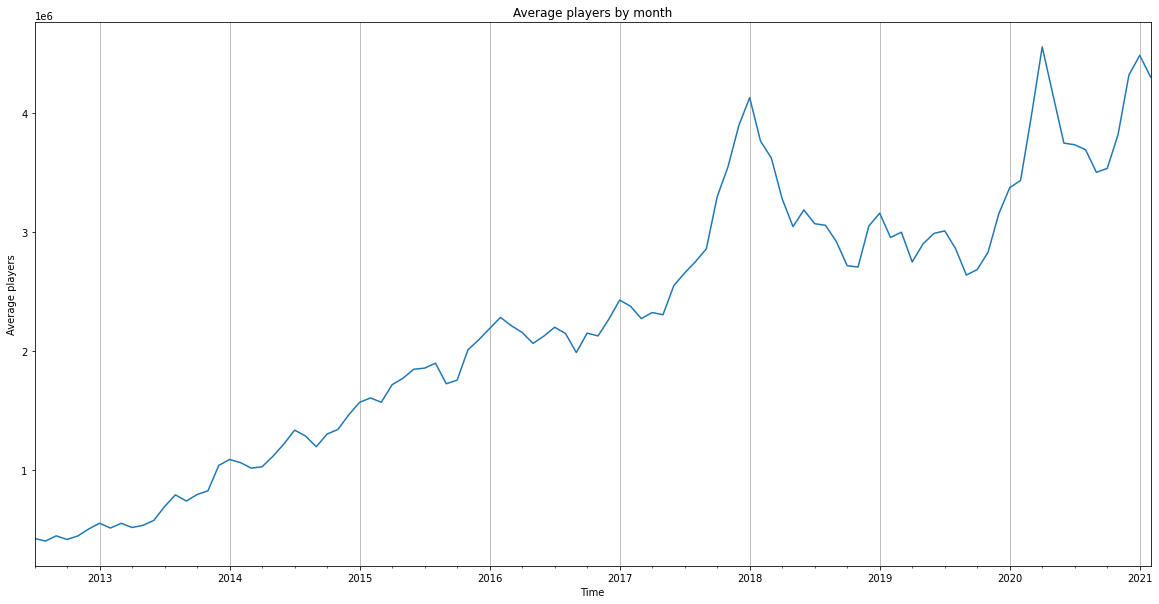

In [23]:
#Evolución del número de jugadores medio en la plataforma steam
df_steam_year = df_steam.groupby(['date'])['avg'].sum().plot(figsize=(20,10))
plt.title("Average players by month")
plt.xlabel("Time")
plt.ylabel("Average players")
plt.gca().xaxis.grid(True); #ejes verticales

Vemos como hay dos incrementos destacados de jugadores. Uno en 2018 y otro en 2020.
El de 2020 se debe principalmente al covid-19 y los confinamientos derivados. Al pasar más tiempo en casa la gente buscaba diferentes formas de entretenimiento.

In [24]:
# Analizamos el por qué del incremento de 2018. Seleccionamos las fechas donde vemos el pico
start_date = '2017-11-01'
end_date = '2018-06-01'

In [25]:
mask_2018 = (df_steam['date'] > start_date) & (df_steam['date'] <= end_date)
df_steam_2018 = df_steam.loc[mask_2018]
df_steam_2018_sort = df_steam_2018.sort_values(by=['avg'], ascending=False)
df_steam_2018_sort.head(10)

,gamename,year,month,avg,gain,peak,avg_peak_perc,date
245,PLAYERUNKNOWN'S BATTLEGROUNDS,2018,January,1584886.77,148728.26,3236027,48.9763%,2018-01-01
246,PLAYERUNKNOWN'S BATTLEGROUNDS,2017,December,1436158.51,101988.42,3080769,46.6169%,2017-12-01
244,PLAYERUNKNOWN'S BATTLEGROUNDS,2018,February,1391015.30,-193871.48,2934761,47.3979%,2018-02-01
243,PLAYERUNKNOWN'S BATTLEGROUNDS,2018,March,1295408.59,-95606.71,2799269,46.2767%,2018-03-01
242,PLAYERUNKNOWN'S BATTLEGROUNDS,2018,April,1107181.80,-188226.79,2456361,45.0741%,2018-04-01
241,PLAYERUNKNOWN'S BATTLEGROUNDS,2018,May,876180.64,-231001.16,2175704,40.2711%,2018-05-01
240,PLAYERUNKNOWN'S BATTLEGROUNDS,2018,June,800668.23,-75512.41,1750216,45.7468%,2018-06-01
142,Dota 2,2017,December,513074.33,25693.09,864939,59.3191%,2017-12-01
141,Dota 2,2018,January,486861.91,-26212.42,778627,62.5283%,2018-01-01
137,Dota 2,2018,May,474325.87,43984.93,844713,56.1523%,2018-05-01


Vemos como el juego que hace que las métricas se disparen en 2018 es PLAYERUNKNOWN'S BATTLEGROUNDS y es porque popularizó junto con Fornite un nuevo modelo de juego llamado Battle Royale

### Top 10 juegos más jugados en Steam en los últimos 10 años

En esta sección vamos a ver cuáles son los juegos más populares de los últimos 10 años de Steam

In [26]:
#Agrupamos los juegos por nombre y número medio de jugadores
df_steam_games = df_steam.groupby(['gamename'])['avg'].sum().reset_index()

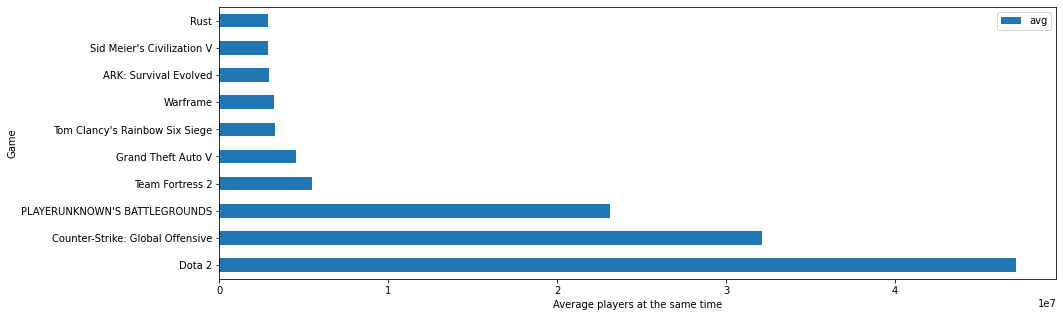

In [27]:
#Ordenamos los juegos y cogemos los 10 primeros. Después los visualizamos en un gráfico de barras horizontal
plt.rcParams["figure.figsize"] = (15,5)
df_steam_games.sort_values('avg', ascending=False).head(10).plot(kind='barh', y='avg', x='gamename')
plt.xlabel("Average players at the same time")
plt.ylabel("Game");

Los juegos más jugados en los últimos 10 años son:
* Dota 2
* Counter_Strike: Global Offensive
* PLAYERUNKNOWN'S BATTLEGROUNDS

### Top 10 juegos más jugados en Steam en los últimos 2 años

Como hemos visto en los gráficos superiores vamos a analizar también el cambio de tendencia que ha habido después del covid-19 en la industria de los videojuegos.

In [28]:
#Filtramos por fechas y creamos un nuevo df
df_top_games_covid = df_steam.loc[(df_steam['year'].isin([2020, 2021]))]

In [29]:
df_top_games_covid.sample(n=7)

,gamename,year,month,avg,gain,peak,avg_peak_perc,date
26975,Rise of the Tomb Raider,2020,May,1742.91,-440.28,4095,42.5619%,2020-05-01
36987,Call of Duty: Black Ops,2020,August,486.74,14.31,1044,46.6226%,2020-08-01
19394,Post Scriptum,2020,May,1124.10,-158.29,2970,37.8485%,2020-05-01
66635,Vampyr,2020,January,186.06,-65.97,494,37.664%,2020-01-01
25538,Left 4 Dead 2,2020,June,11295.42,-656.96,23371,48.3309%,2020-06-01
39520,Counter-Strike: Condition Zero,2020,March,599.17,184.15,1565,38.2856%,2020-03-01
10178,X-Plane 11,2020,August,1743.33,-322.38,3174,54.9253%,2020-08-01


In [30]:
#Comprobamos el rango de años recogidos en el nuevo dataset
year_data = max(df_top_games_covid['year'])-min(df_top_games_covid['year'])
print("Tenemos datos de %d año" % year_data)

Tenemos datos de 1 año


In [31]:
df_games_covid19 = df_top_games_covid.groupby(['gamename'])['avg'].sum().reset_index()

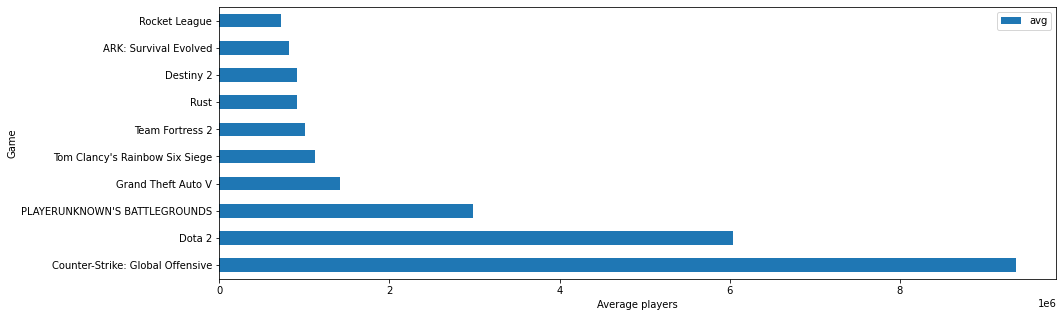

In [32]:
#Ploteamos el gráfico con los juegos más jugados desde el covid-19
plt.rcParams["figure.figsize"] = (15,5)
df_top10_games_covid19 = df_games_covid19.sort_values('avg', ascending=False).head(10).plot(kind='barh', y='avg', x='gamename')
plt.xlabel("Average players")
plt.ylabel("Game");

# Exportamos los datos

Expotamos los datos en csv para utilizarlos en notebooks posteriores

In [33]:
#Exportamos los datos totales de Steam
df_steam.to_csv('Steam data processed.csv', encoding='utf-8', index=False, header=True)


In [34]:
#Exportamos los datos totales de Steam post covid-19
df_top_games_covid.to_csv('Steam data games post covid.csv', encoding='utf-8', index=False, header=True)
